# **Hogwarts House Predictor**


## **Introduction**

Ever wondered which Hogwarts house you truly belong to? In this project, we'll build a machine learning model that acts like the Sorting Hat, predicting which house a student should be sorted into based on their magical abilities and personality traits.
But here's the twist - we'll discover that not all datasets are created equal, and sometimes "perfect" results are actually a red flag! Join me as we explore overfitting, synthetic data generation, and building a more realistic predictor.

## **Setup and Installation**

First, let's install the required packages and import our libraries:

In [1]:
# Install CatBoost - our gradient boosting algorithm of choice
!pip install catboost

In [2]:
# Import necessary libraries
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## **Part 1: The Existing Dataset**

Let's start by downloading the Harry Potter sorting dataset from Kaggle:

In [3]:
# Download dataset
path = kagglehub.dataset_download("sahityapalacharla/harry-potter-sorting-dataset")

# Load CSV file into Pandas DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "sahityapalacharla/harry-potter-sorting-dataset",
    "harry_potter_1000_students.csv"
)

Using Colab cache for faster access to the 'harry-potter-sorting-dataset' dataset.


/tmp/ipython-input-1049650714.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'harry-potter-sorting-dataset' dataset.


In [4]:
print(f"Shape: {df.shape[0]} students, {df.shape[1]} features")
df.head()

Shape: 1000 students, 10 features


,Blood Status,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity,House
0,Half-blood,9,4,7,5,0,8,8,7,Gryffindor
1,Muggle-born,6,8,5,7,5,6,4,9,Ravenclaw
2,Pure-blood,1,4,7,7,1,4,4,6,Hufflepuff
3,Pure-blood,9,1,3,4,1,9,10,1,Gryffindor
4,Muggle-born,5,9,7,3,3,6,7,9,Ravenclaw


### **Preparing the Data**

 Define Features/Target

In [5]:
X = df.drop("House", axis=1)
y = df["House"]

Categorical features (CatBoost handles these directly)

In [6]:
categorical_features = ["Blood Status"]

In [7]:
print("Features:", list(X.columns))
print("Target classes:", list(y.unique()))

Features: ['Blood Status', 'Bravery', 'Intelligence', 'Loyalty', 'Ambition', 'Dark Arts Knowledge', 'Quidditch Skills', 'Dueling Skills', 'Creativity']
Target classes: ['Gryffindor', 'Ravenclaw', 'Hufflepuff', 'Slytherin']


### **Training the First Model**

Train-test split

In [8]:
X_train, X_test, y_train, y_test= train_test_split(
    X,y, test_size=0.3,random_state=42,stratify=y)

Train CatBoost Model

In [9]:
model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function="MultiClass",
    verbose=100,
    random_seed=42
)

Fit the model

In [10]:
model.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 1.1809873	total: 51.3ms	remaining: 25.6s
100:	learn: 0.0152041	total: 295ms	remaining: 1.17s
200:	learn: 0.0066131	total: 532ms	remaining: 792ms
300:	learn: 0.0041338	total: 798ms	remaining: 527ms
400:	learn: 0.0029836	total: 1.03s	remaining: 254ms
499:	learn: 0.0023407	total: 1.27s	remaining: 0us


### **Evaluate The Model**

In [11]:
y_pred = model.predict(X_test)

In [12]:
print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 1.0

 Classification Report:
               precision    recall  f1-score   support

  Gryffindor       1.00      1.00      1.00        68
  Hufflepuff       1.00      1.00      1.00        75
   Ravenclaw       1.00      1.00      1.00        77
   Slytherin       1.00      1.00      1.00        80

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Confusion Matrix

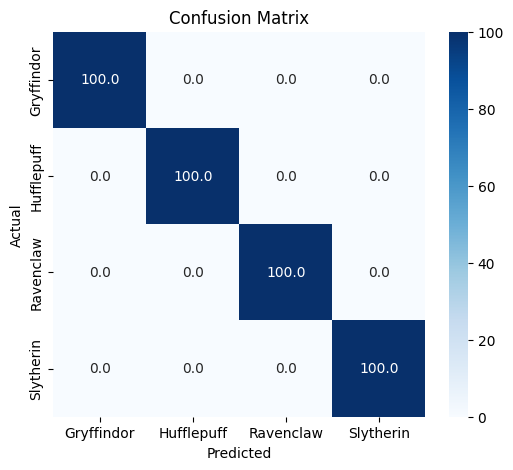

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Wait a minute... 100% accuracy?
This looks suspicious! Let's investigate why our model performed too well:

**Analyze feature importance**

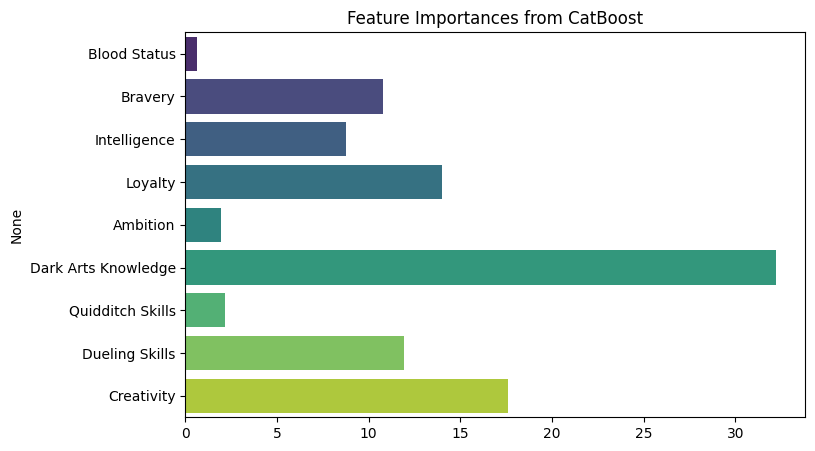

In [14]:
feature_importances = model.get_feature_importance()
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(
    x=feature_importances,
    y=features,
    hue=features,
    palette="viridis",
    legend=False
)
plt.title("Feature Importances from CatBoost")
plt.show()

Check house-wise feature patterns

In [15]:
df.groupby("House")[df.select_dtypes(include="number").columns].mean()

,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity
House,,,,,,,,
Gryffindor,8.615044,4.318584,3.977876,3.880531,2.194690,7.460177,8.761062,4.084071
Hufflepuff,3.844622,4.171315,8.509960,4.011952,2.470120,3.673307,3.860558,4.027888
Ravenclaw,4.124031,8.546512,3.922481,3.844961,2.573643,3.604651,4.023256,8.635659
Slytherin,3.962264,3.973585,4.083019,8.528302,8.528302,7.252830,8.437736,3.947170



### **The Revelation: What the Model Really Learned**
The feature importance analysis has uncovered the smoking gun! Here’s the truth behind the Sorting Hat predictions:

**The “Lookup Table” Pattern**

| Trait               | Importance | What it Means                     |
| ------------------- | ---------- | --------------------------------- |
| Dark Arts Knowledge | \~28       | If high → must be **Slytherin**   |
| Creativity          | \~18       | If high → likely **Ravenclaw**    |
| Loyalty             | \~14       | If high → probably **Hufflepuff** |
| Bravery             | \~7        | If high → Gryffindor              |


**House-wise Feature Patterns**

| House      | Dominant Traits                           |
| ---------- | ----------------------------------------- |
| Gryffindor | Bravery (8.6), Dueling Skills (8.8)       |
| Hufflepuff | Loyalty (8.5)                             |
| Ravenclaw  | Intelligence (8.5), Creativity (8.6)      |
| Slytherin  | Ambition (8.5), Dark Arts Knowledge (8.5) |


**The Problem**
The dataset is **too cleanly separated**. Each house has a single dominant “signature” trait with zero overlap. The model **didn’t learn complex patterns** , it memorized a simple lookup table:

   
    IF Dark Arts Knowledge > 7 → Slytherin
    ELIF Creativity > 7 → Ravenclaw
    ELIF Loyalty > 7 → Hufflepuff
    ELSE → Gryffindor
   


Reality Check: This isn’t realistic! In the real world - or even in the Harry Potter universe - people have **complex, overlapping personalities**. A brave Ravenclaw or a creative Slytherin should be possible!


## **Part 2: Creating a Realistic Dataset**

Let’s create 1000 new students with random values, making them realistic but varied so the model doesn’t just memorize patterns

In [16]:
n_students = 1000
houses = ["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"]
students = []

for house in houses:
        for _ in range(n_students // 4):
            if house == "Gryffindor":
                # Gryffindors tend to be brave but can have other strong traits too
                bravery = np.random.randint(6, 10)
                intelligence = np.random.randint(4, 8)
                loyalty = np.random.randint(3, 7)
                ambition = np.random.randint(3, 7)
                dark_arts = np.random.randint(1, 5)
            elif house == "Hufflepuff":
                # Hufflepuffs are loyal but not exclusively so
                bravery = np.random.randint(3, 7)
                intelligence = np.random.randint(4, 8)
                loyalty = np.random.randint(6, 10)
                ambition = np.random.randint(3, 7)
                dark_arts = np.random.randint(1, 5)
            elif house == "Ravenclaw":
                # Ravenclaws are intelligent and creative
                bravery = np.random.randint(3, 7)
                intelligence = np.random.randint(6, 10)
                loyalty = np.random.randint(3, 7)
                ambition = np.random.randint(3, 7)
                dark_arts = np.random.randint(1, 5)
            elif house == "Slytherin":
                # Slytherins are ambitious with dark arts knowledge
                bravery = np.random.randint(3, 7)
                intelligence = np.random.randint(4, 8)
                loyalty = np.random.randint(3, 7)
                ambition = np.random.randint(6, 10)
                dark_arts = np.random.randint(5, 9)

            students.append({
                "House": house,
                "Bravery": bravery,
                "Intelligence": intelligence,
                "Loyalty": loyalty,
                "Ambition": ambition,
                "Dark Arts Knowledge": dark_arts,
                "Quidditch Skills": np.random.randint(3, 9),
                "Dueling Skills": np.random.randint(3, 9),
                "Creativity": np.random.randint(3, 9),
                "Blood Status": np.random.choice(["Muggle-born", "Half-blood", "Pure-blood"])
            })

df_new = pd.DataFrame(students)
df_new = df_new.sample(frac=1, random_state=42).reset_index(drop=True)



Now we can append it to our original Kaggle dataset

In [17]:
df_combined = pd.concat([df, df_new], ignore_index=True)

# Shuffle the combined dataset to mix old and new students
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

Adding Noise for Realism

In [18]:
numeric_cols = ["Bravery", "Intelligence", "Loyalty", "Ambition", "Dark Arts Knowledge",
                "Quidditch Skills", "Dueling Skills", "Creativity"]

# Add Gaussian noise
for col in numeric_cols:
    df_combined[col] += np.random.normal(0, 0.5, size=len(df_combined))

# Clip values to 1-10
df_combined[numeric_cols] = df_combined[numeric_cols].clip(1, 10)


In [19]:

print(f"Combined dataset shape: {df_combined.shape}")
df_combined.head()



Combined dataset shape: (2000, 10)


,Blood Status,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity,House
0,Half-blood,3.102068,5.982297,8.292599,2.396270,1.295937,8.467717,5.749302,2.579018,Hufflepuff
1,Pure-blood,5.723553,7.034147,2.277929,5.694496,1.000000,2.671105,6.019195,9.344359,Ravenclaw
2,Half-blood,6.024276,9.944565,3.099217,1.871083,2.285670,5.828938,3.539346,2.384150,Ravenclaw
3,Muggle-born,6.564014,5.325725,8.667095,2.436529,2.625548,7.095590,1.000000,5.386336,Hufflepuff
4,Pure-blood,5.696231,3.786471,4.689059,6.403491,6.144410,4.997145,7.271046,6.041687,Slytherin


In [20]:
df_combined.groupby("House")[numeric_cols].mean()

,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity
House,,,,,,,,
Gryffindor,8.011046,4.890423,4.320032,4.231592,2.502861,6.360984,7.052959,4.791984
Hufflepuff,4.160550,4.757481,8.019822,4.244945,2.610974,4.662656,4.680350,4.731227
Ravenclaw,4.311630,8.005032,4.272313,4.097890,2.630398,4.593125,4.762661,7.136435
Slytherin,4.269198,4.679358,4.316521,7.988928,7.578285,6.485412,7.022382,4.783860


## **Part 3: Training on Realistic Data**

In [21]:
# Prepare the realistic dataset
X_new = df_combined.drop("House", axis=1)
y_new = df_combined["House"]
categorical_features = ["Blood Status"]

#Split the data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.3, random_state=42, stratify=y_new
)

# Train a new model on realistic data
model_new = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function="MultiClass",
    verbose=100,
    random_seed=42
)

model_new.fit(X_train_new, y_train_new, cat_features=categorical_features)


0:	learn: 1.1994403	total: 10.8ms	remaining: 5.4s
100:	learn: 0.1153713	total: 828ms	remaining: 3.27s
200:	learn: 0.0681143	total: 2.38s	remaining: 3.54s
300:	learn: 0.0452632	total: 3.35s	remaining: 2.21s
400:	learn: 0.0326848	total: 4.29s	remaining: 1.06s
499:	learn: 0.0254213	total: 5.54s	remaining: 0us


### **Results**

Predict on realistic test set

In [22]:
# Predict house labels
y_pred_new = model_new.predict(X_test_new)

# Predict probabilities
y_probs_new = model_new.predict_proba(X_test_new)


In [23]:
model_new.save_model("the_sorting_hat_2.0_model.cbm")

Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

  Gryffindor       0.94      0.93      0.93       143
  Hufflepuff       0.91      0.95      0.93       150
   Ravenclaw       0.92      0.89      0.91       152
   Slytherin       1.00      0.98      0.99       155

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



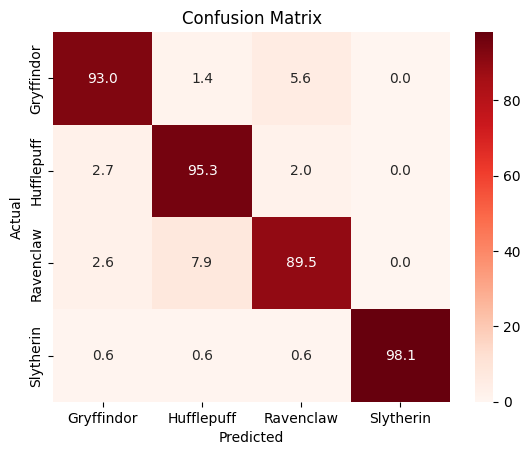

In [24]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_new, y_pred_new))

# Detailed metrics
print("\nClassification Report:\n", classification_report(y_test_new, y_pred_new))

cm_new = confusion_matrix(y_test_new, y_pred_new, labels=model.classes_)
cm_percent_new = cm_new.astype('float') / cm_new.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent_new, annot=True, fmt=".1f", cmap="Reds",
            xticklabels=model_new.classes_, yticklabels=model_new.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Now we have a realistic result!




## **Part 4: The Sorting Hat in Action**

In [25]:
def sort_student(name, blood_status, bravery, intelligence, loyalty, ambition,
                 dark_arts, quidditch, dueling, creativity, model=model_new, threshold=0.15):


    # Create student data
    student = pd.DataFrame([{
        "Blood Status": blood_status,
        "Bravery": bravery,
        "Intelligence": intelligence,
        "Loyalty": loyalty,
        "Ambition": ambition,
        "Dark Arts Knowledge": dark_arts,
        "Quidditch Skills": quidditch,
        "Dueling Skills": dueling,
        "Creativity": creativity
    }])

    # Specify categorical columns
    cat_features = ["Blood Status"]

    # Create CatBoost Pool
    student_pool = Pool(data=student, cat_features=cat_features)

    # Make prediction
    predicted_house = model.predict(student_pool).item()
    probabilities = model.predict_proba(student_pool)[0]
    prob_dict = dict(zip(model.classes_, probabilities))

    # Sort probabilities
    sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
    top_house, top_prob = sorted_probs[0]
    second_house, second_prob = sorted_probs[1]

    # Check if probabilities are close
    close_message = ""
    if top_prob - second_prob < threshold:
        close_message = "You have multiple strong traits that made it difficult to place you in one house, " \
                        "but a Sorting Hat never fails! "

    # House emojis and messages
    house_emoji = {"Gryffindor": "🦁", "Hufflepuff": "🦡", "Ravenclaw": "🦅", "Slytherin": "🐍"}
    house_messages = {
        "Gryffindor": ["Your courage and daring spirit make you a true Gryffindor!"],
        "Hufflepuff": ["Your loyalty and dedication shine bright in Hufflepuff!"],
        "Ravenclaw": ["Your wisdom and creativity belong in Ravenclaw!"],
        "Slytherin": ["Your ambition and cunning mark you as a true Slytherin!"]
    }

    # Pick message
    selected_message = random.choice(house_messages[predicted_house])

    # Traits per house for message alignment
    house_traits = {
        "Gryffindor": ["Bravery", "Ambition"],
        "Hufflepuff": ["Loyalty", "Bravery"],
        "Ravenclaw": ["Intelligence", "Creativity"],
        "Slytherin": ["Ambition", "Dark Arts Knowledge"]
    }
    top_traits = house_traits[predicted_house]

    # Create personalized message
    message = f"🎓 {name}, welcome to {predicted_house}! {house_emoji[predicted_house]}\n\n"
    message += f"The Sorting Hat has spoken! You are exceptional in {top_traits[0].lower()} and {top_traits[1].lower()}. "
    message += "But remember, your house placement considers all your traits — bravery, intelligence, loyalty, ambition, dark arts knowledge, and more. "
    message += close_message + selected_message

    # Show all house probabilities
    message += "\n\n House Probabilities:"
    for house, prob in sorted_probs:
        emoji = house_emoji[house]
        message += f"\n{emoji} {house}: {prob:.1%}"

    message += "\n\n✨ May your journey at Hogwarts be filled with magic and wonder!"

    return message


Now let's test our Sorting Hat on a new student!

In [26]:
result = sort_student(
    name="Emma",
    blood_status="Half-blood",
    bravery=8,
    intelligence=9,
    loyalty=10,
    ambition=3,
    dark_arts=3,
    quidditch=10,
    dueling=8,
    creativity=9
)

print(result)

🎓 Emma, welcome to Ravenclaw! 🦅

The Sorting Hat has spoken! You are exceptional in intelligence and creativity. But remember, your house placement considers all your traits — bravery, intelligence, loyalty, ambition, dark arts knowledge, and more. Your wisdom and creativity belong in Ravenclaw!

 House Probabilities:
🦅 Ravenclaw: 54.0%
🦁 Gryffindor: 38.0%
🦡 Hufflepuff: 6.3%
🐍 Slytherin: 1.6%

✨ May your journey at Hogwarts be filled with magic and wonder!


In [27]:
result = sort_student(
    name="Dan",
    blood_status="Half-blood",
    bravery=10,
    intelligence=8,
    loyalty=3,
    ambition=3,
    dark_arts=3,
    quidditch=5,
    dueling=8,
    creativity=6
)

print(result)

🎓 Dan, welcome to Gryffindor! 🦁

The Sorting Hat has spoken! You are exceptional in bravery and ambition. But remember, your house placement considers all your traits — bravery, intelligence, loyalty, ambition, dark arts knowledge, and more. Your courage and daring spirit make you a true Gryffindor!

 House Probabilities:
🦁 Gryffindor: 96.2%
🦅 Ravenclaw: 3.6%
🦡 Hufflepuff: 0.1%
🐍 Slytherin: 0.1%

✨ May your journey at Hogwarts be filled with magic and wonder!


## **Conclusion**

We've successfully built a Hogwarts House predictor that learned an important lesson: not all perfect results are actually perfect!
Sometimes the messier, more realistic approach leads to a better, more generalizable model.

The Sorting Hat taught us that in machine learning, as in magic, the journey of understanding your data is just as important as the destination of high accuracy.

*"It is our choices, Harry, that show what we truly are, far more than our abilities."* - And sometimes, that includes choosing realistic data over perfect results!

Happy coding, and may the odds be ever in your favor... I mean, may your house win the House Cup! 🏆